## Here we explore a custom self sampled datset. The datset was sampled from FMA

In [1]:
import os
import pandas as pd
from mutagen.mp3 import MP3

In [2]:
def get_genre_stats(root_dir):
    # Expand the tilde to the full home directory path
    root_dir = os.path.expanduser(root_dir)
    
    data = []
    for genre in os.listdir(root_dir):
        genre_dir = os.path.join(root_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        
        num_tracks = 0
        total_duration = 0.0
        
        for file in os.listdir(genre_dir):
            if file.endswith('.mp3'):
                file_path = os.path.join(genre_dir, file)
                try:
                    audio = MP3(file_path)
                    total_duration += audio.info.length
                    num_tracks += 1
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
        
        data.append({
            'genre': genre,
            'number_of_tracks': num_tracks,
            'total_duration_seconds': total_duration
        })
    
    return pd.DataFrame(data)

In [3]:
df = get_genre_stats('~/data/project/music')

In [4]:
df.head()

genre  number_of_tracks  total_duration_seconds
0  rock-garage                20             5503.931850
1          pop                27             6505.923819
2        metal                22             7623.526349
3        blues                33             8262.251099
4          rnb                24             6087.068005

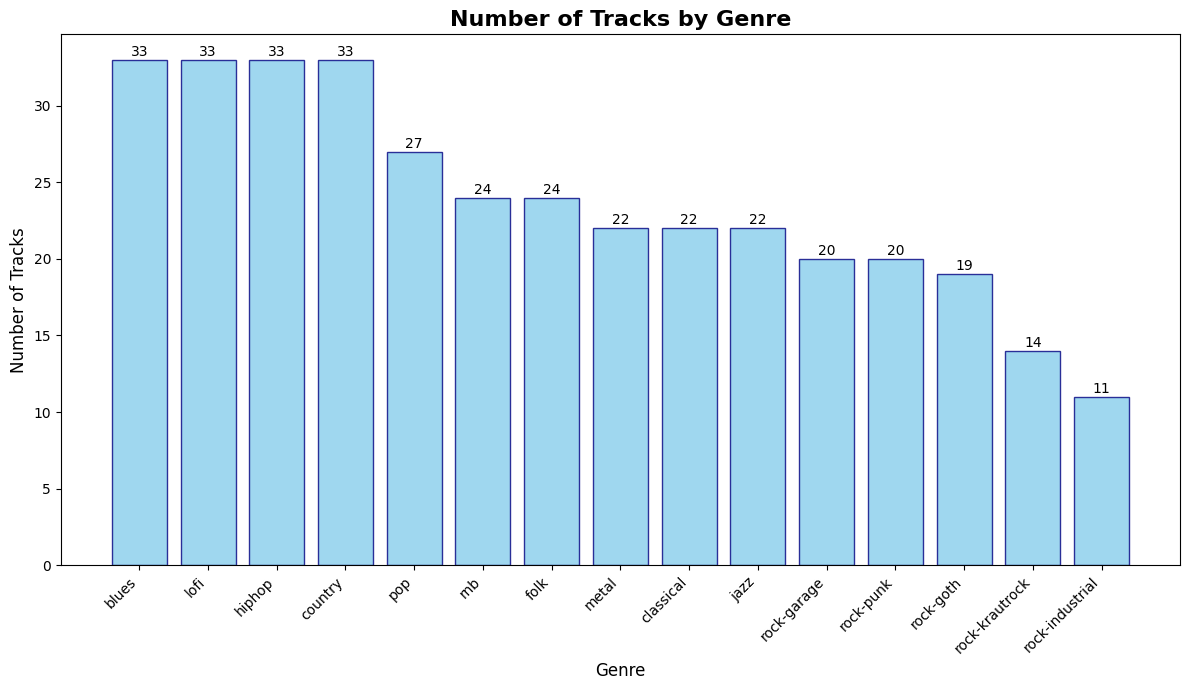

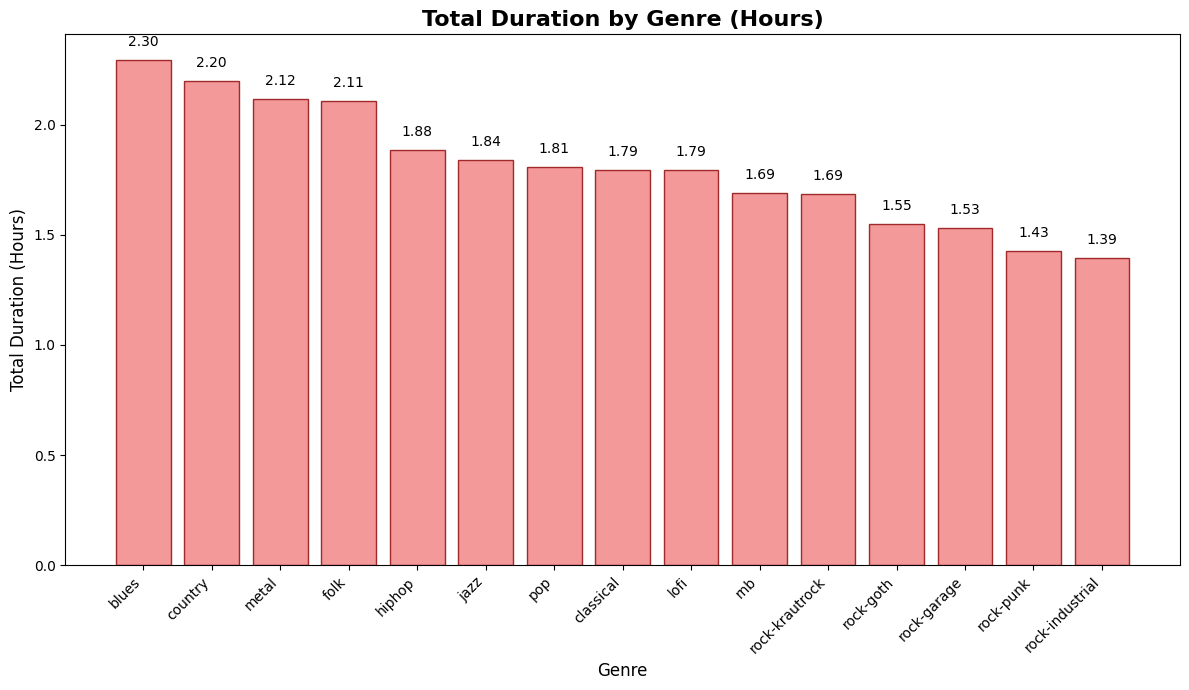

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

df = get_genre_stats('~/data/project/music')
# Assuming you already have your DataFrame 'df' from the previous function

# Convert total duration from seconds to hours for better readability
df['total_duration_hours'] = df['total_duration_seconds'] / 3600

# Sort the DataFrame by number of tracks for better visualization
df_sorted_tracks = df.sort_values('number_of_tracks', ascending=False)

# First plot: Number of tracks per genre
plt.figure(figsize=(12, 7))
bars = plt.bar(df_sorted_tracks['genre'], df_sorted_tracks['number_of_tracks'], 
               color='skyblue', edgecolor='navy', alpha=0.8)
plt.title('Number of Tracks by Genre', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Tracks', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Sort the DataFrame by total duration for better visualization
df_sorted_duration = df.sort_values('total_duration_hours', ascending=False)

# Second plot: Total duration per genre
plt.figure(figsize=(12, 7))
bars = plt.bar(df_sorted_duration['genre'], df_sorted_duration['total_duration_hours'], 
               color='lightcoral', edgecolor='darkred', alpha=0.8)
plt.title('Total Duration by Genre (Hours)', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Total Duration (Hours)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [6]:
import os
import random
import pandas as pd

def get_random_mp3s(root_dir, sample_size=5):
    root_dir = os.path.expanduser(root_dir)
    mp3_list = []

    # Traverse through all genre directories
    for genre in os.listdir(root_dir):
        genre_dir = os.path.join(root_dir, genre)
        if not os.path.isdir(genre_dir):
            continue
        
        # Collect all MP3 files with their genre
        for file in os.listdir(genre_dir):
            if file.endswith('.mp3'):
                mp3_list.append({
                    'genre': genre,
                    'filename': file
                })

    # Randomly sample the list of MP3s
    if len(mp3_list) < sample_size:
        print(f"Warning: Only {len(mp3_list)} MP3s found, returning all available")
        sample = mp3_list
    else:
        sample = random.sample(mp3_list, sample_size)

    return pd.DataFrame(sample)

In [7]:
df_random_mp3s = get_random_mp3s('~/data/project/music', sample_size=5)

In [8]:
df_random_mp3s.head()

genre                                           filename
0          rnb                         Serge Quadrado - Honey.mp3
1  rock-garage   OBN IIIs - Heavy Heart_No Time For The Blues.mp3
2          pop                      SUPERARE - In Your Dreams.mp3
3    rock-punk  Deaf Wish - Gentle Mental Illness_Nerve Damage...
4         lofi  Aldous Ichnite - Somehow This Elevator Only Go...

In [15]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import librosa
import librosa.display

def extract_consistent_snippets(root_dir, df, snippet_duration=15, target_sample_rate=16000):
    """
    Extract audio snippets with consistent temporal properties.
    
    Parameters:
    root_dir (str): Root directory containing genre subdirectories
    df (DataFrame): DataFrame with 'genre' and 'filename' columns
    snippet_duration (int): Duration of the snippet in seconds
    target_sample_rate (int): Target sample rate for all audio (default: 22050 Hz)
    
    Returns:
    list: List of dictionaries containing consistent snippet data
    """
    root_dir = os.path.expanduser(root_dir)
    snippets = []
    
    for idx, row in df.iterrows():
        try:
            # Build file path
            file_path = os.path.join(root_dir, row['genre'], row['filename'])
            
            # Load audio with librosa to ensure consistent sample rate
            audio, orig_sr = librosa.load(file_path, sr=target_sample_rate)
            
            # Calculate total duration in samples
            total_samples = len(audio)
            total_duration = total_samples / target_sample_rate
            
            # Calculate start and end points for the middle snippet
            start_sample = int(max(0, (total_samples - snippet_duration * target_sample_rate) / 2))
            end_sample = start_sample + snippet_duration * target_sample_rate
            
            # Extract snippet
            snippet_audio = audio[start_sample:end_sample]
            
            # Ensure all snippets have exactly the same length
            # (pad with zeros if needed, though this shouldn't happen with middle extraction)
            if len(snippet_audio) < snippet_duration * target_sample_rate:
                padding = np.zeros(snippet_duration * target_sample_rate - len(snippet_audio))
                snippet_audio = np.concatenate([snippet_audio, padding])
            
            # Create time axis (consistent across all snippets)
            times = np.linspace(0, snippet_duration, len(snippet_audio))
            
            # Store all data
            snippets.append({
                'genre': row['genre'],
                'filename': row['filename'],
                'full_path': file_path,
                'snippet_duration': snippet_duration,
                'start_time': start_sample / target_sample_rate,  # Start time in seconds
                'sample_rate': target_sample_rate,
                'samples': snippet_audio,
                'times': times,
                'waveform_data': (times, snippet_audio)
            })
            
        except Exception as e:
            print(f"Error processing {row['filename']}: {e}")
    
    return snippets

def plot_consistent_snippets(snippets, figsize=(12, 8)):
    """
    Plot waveforms of audio snippets with consistent temporal properties.
    
    Parameters:
    snippets (list): List of snippet dictionaries from extract_consistent_snippets
    figsize (tuple): Figure size (width, height)
    """
    n = len(snippets)
    fig, axes = plt.subplots(n, 1, figsize=figsize)
    if n == 1:
        axes = [axes]  # Make it iterable for single subplot case
    
    for i, snippet in enumerate(snippets):
        times, samples = snippet['waveform_data']
        axes[i].plot(times, samples)
        axes[i].set_title(f"{snippet['genre']} - {snippet['filename']}")
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].set_xlim(0, snippet['snippet_duration'])  # Consistent x-axis
        axes[i].grid(True)
    
    plt.tight_layout()
    return fig

def create_comparison_plot(snippets, figsize=(15, 10)):
    """
    Create a comparison plot with all snippets on the same axes for direct comparison.
    
    Parameters:
    snippets (list): List of snippet dictionaries from extract_consistent_snippets
    figsize (tuple): Figure size (width, height)
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(snippets)))
    
    for i, snippet in enumerate(snippets):
        times, samples = snippet['waveform_data']
        # Normalize amplitude for better comparison
        normalized_samples = samples / np.max(np.abs(samples))
        ax.plot(times, normalized_samples + i, 
                label=f"{snippet['genre']} - {snippet['filename']}",
                color=colors[i])
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude (offset by track)')
    ax.set_title('Comparison of Audio Snippets (Normalized and Offset)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    return fig

def extract_spectrograms(snippets, n_fft=2048, hop_length=512):
    """
    Extract spectrograms from audio snippets for frequency analysis.
    
    Parameters:
    snippets (list): List of snippet dictionaries from extract_consistent_snippets
    n_fft (int): FFT window size
    hop_length (int): Hop length for STFT
    
    Returns:
    list: List of dictionaries with added spectrogram data
    """
    for snippet in snippets:
        # Compute spectrogram
        stft = librosa.stft(snippet['samples'], n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft)
        db_spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
        
        # Add to snippet dictionary
        snippet['spectrogram'] = db_spectrogram
        snippet['stft_params'] = {'n_fft': n_fft, 'hop_length': hop_length}
    
    return snippets

def plot_spectrograms(snippets, figsize=(15, 12)):
    """
    Plot spectrograms of audio snippets.
    
    Parameters:
    snippets (list): List of snippet dictionaries with spectrogram data
    figsize (tuple): Figure size (width, height)
    """
    n = len(snippets)
    fig, axes = plt.subplots(n, 1, figsize=figsize)
    if n == 1:
        axes = [axes]  # Make it iterable for single subplot case
    
    for i, snippet in enumerate(snippets):
        # Create frequency and time axes for spectrogram
        hop_length = snippet['stft_params']['hop_length']
        n_fft = snippet['stft_params']['n_fft']
        
        # Time axis in seconds
        times = np.linspace(0, snippet['snippet_duration'], 
                           snippet['spectrogram'].shape[1])
        
        # Frequency axis in Hz
        freqs = librosa.fft_frequencies(sr=snippet['sample_rate'], n_fft=n_fft)
        
        # Plot spectrogram
        img = librosa.display.specshow(snippet['spectrogram'], 
                                      x_axis='time', 
                                      y_axis='log', 
                                      sr=snippet['sample_rate'],
                                      hop_length=hop_length,
                                      ax=axes[i])
        
        axes[i].set_title(f"Spectrogram: {snippet['genre']} - {snippet['filename']}")
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")
    
    plt.tight_layout()
    return fig

# Example usage:
# Get random MP3s
# df_random = get_random_mp3s('~/music_directory')
# Extract consistent snippets
# snippets = extract_consistent_snippets('~/music_directory', df_random)
# Plot waveforms
# fig1 = plot_consistent_snippets(snippets)
# Create comparison plot
# fig2 = create_comparison_plot(snippets)
# Extract and plot spectrograms
# snippets_with_spec = extract_spectrograms(snippets)
# fig3 = plot_spectrograms(snippets_with_spec)
# plt.show()

In [16]:
snippets = extract_consistent_snippets('~/data/project/music', df_random_mp3s)

In [17]:
snippets

[{'genre': 'rnb',
  'filename': 'Serge Quadrado - Honey.mp3',
  'full_path': '/Users/peeyushpatel/data/project/music/rnb/Serge Quadrado - Honey.mp3',
  'snippet_duration': 15,
  'start_time': 51.1840625,
  'sample_rate': 16000,
  'samples': array([-0.08755408, -0.13195437, -0.11536998, ..., -0.07543375,
         -0.05163001, -0.0138997 ], shape=(240000,), dtype=float32),
  'times': array([0.00000000e+00, 6.25002604e-05, 1.25000521e-04, ...,
         1.49998750e+01, 1.49999375e+01, 1.50000000e+01], shape=(240000,)),
  'waveform_data': (array([0.00000000e+00, 6.25002604e-05, 1.25000521e-04, ...,
          1.49998750e+01, 1.49999375e+01, 1.50000000e+01], shape=(240000,)),
   array([-0.08755408, -0.13195437, -0.11536998, ..., -0.07543375,
          -0.05163001, -0.0138997 ], shape=(240000,), dtype=float32))},
 {'genre': 'rock-garage',
  'filename': 'OBN IIIs - Heavy Heart_No Time For The Blues.mp3',
  'full_path': '/Users/peeyushpatel/data/project/music/rock-garage/OBN IIIs - Heavy Heart_N

In [18]:
import numpy as np
from IPython.display import Audio, display
import soundfile as sf
import io

def play_snippet(snippet, autoplay=False):
    """
    Play an audio snippet in Jupyter notebook.
    
    Parameters:
    snippet (dict): A snippet dictionary from extract_consistent_snippets
    autoplay (bool): Whether to autoplay the audio (default: False)
    """
    return Audio(data=snippet['samples'], rate=snippet['sample_rate'], autoplay=autoplay)

In [20]:
play_snippet(snippets[1])

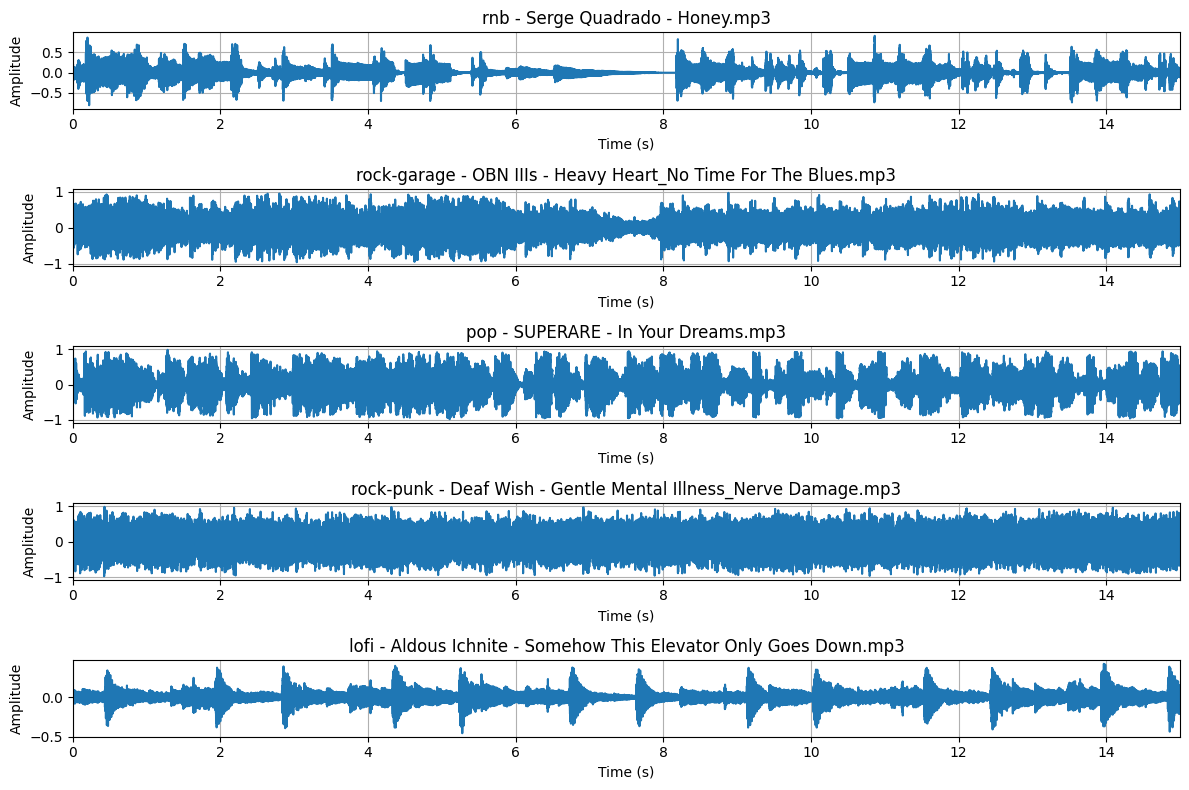

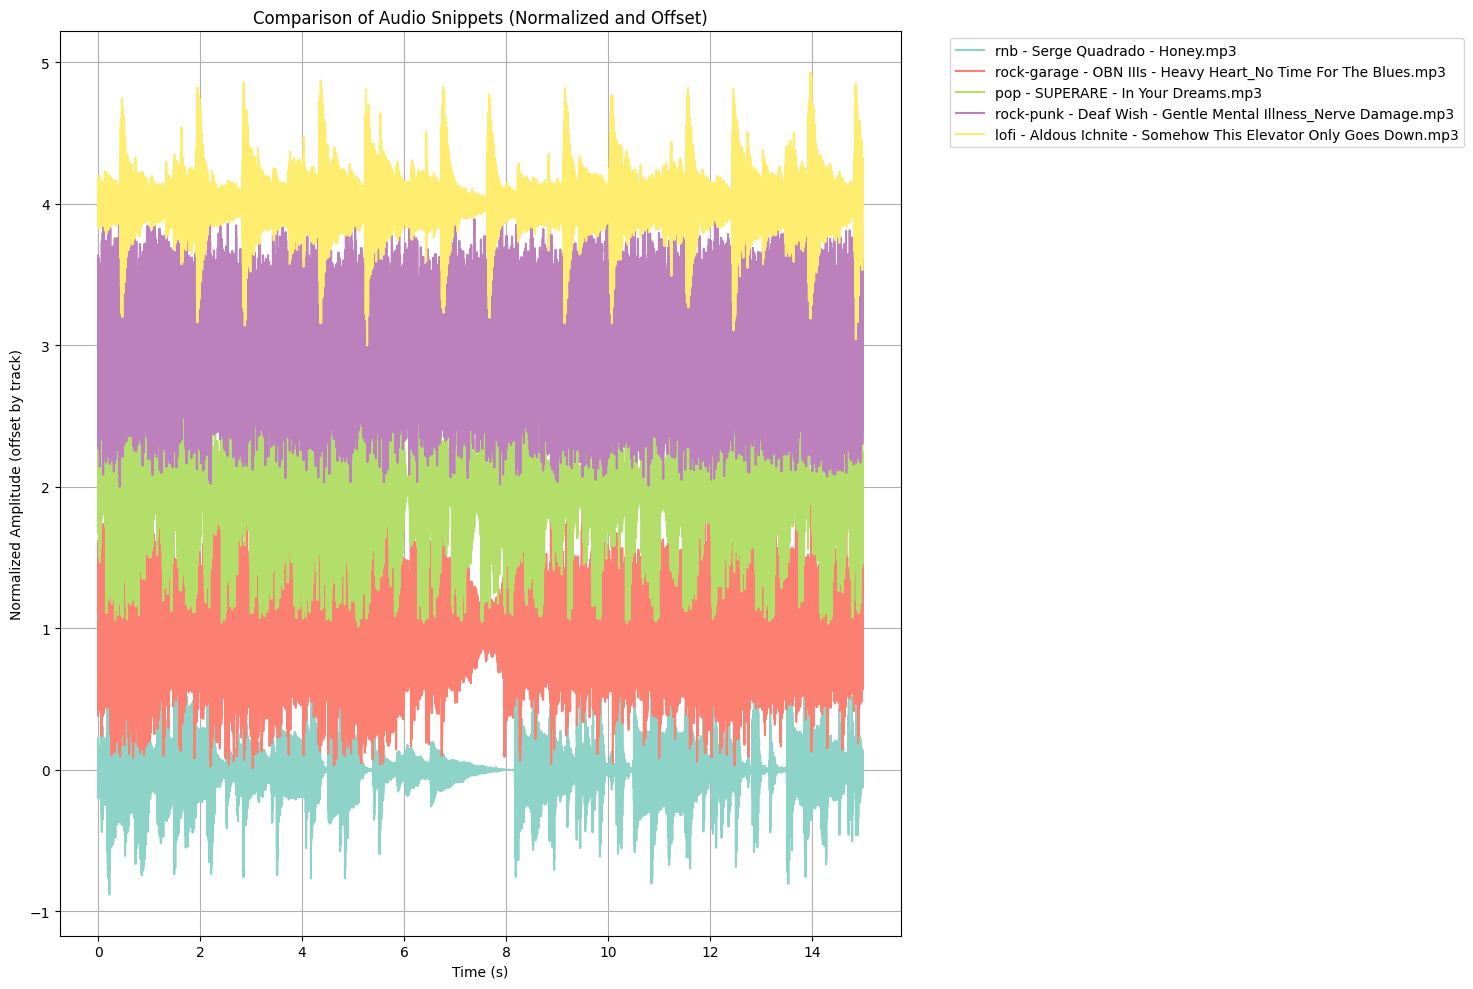

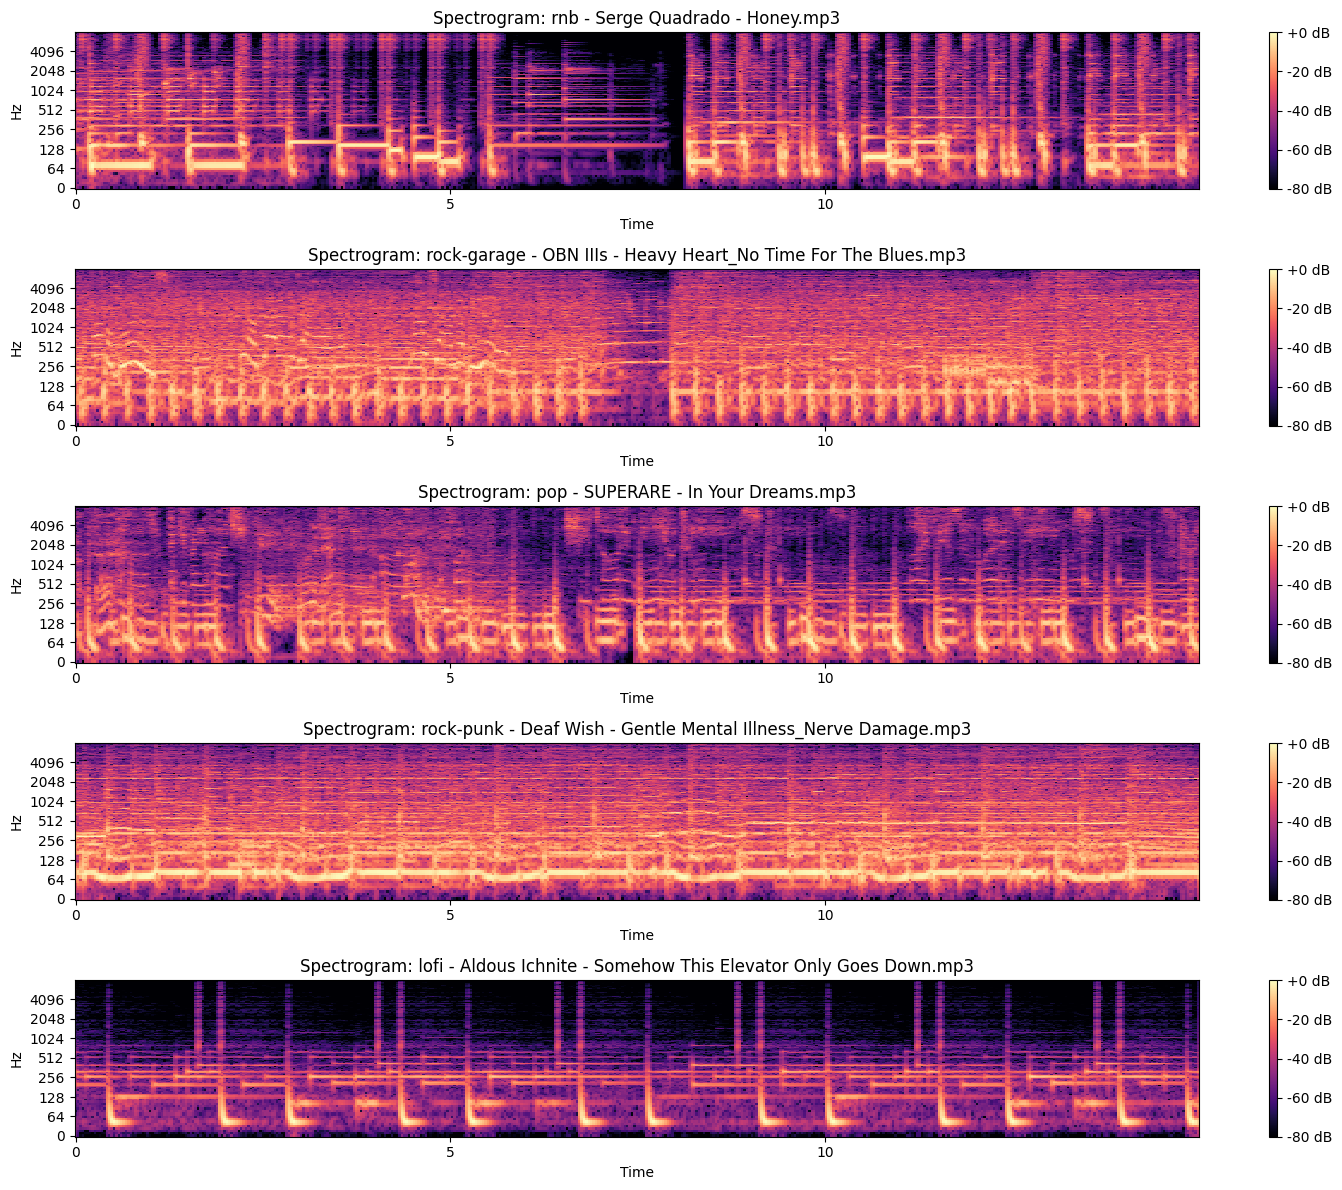

In [21]:
# Plot waveforms
fig1 = plot_consistent_snippets(snippets)
# Create comparison plot
fig2 = create_comparison_plot(snippets)
# Extract and plot spectrograms
snippets_with_spec = extract_spectrograms(snippets)
fig3 = plot_spectrograms(snippets_with_spec)
plt.show()

In [22]:
snippets_with_spec[0]

{'genre': 'rnb',
 'filename': 'Serge Quadrado - Honey.mp3',
 'full_path': '/Users/peeyushpatel/data/project/music/rnb/Serge Quadrado - Honey.mp3',
 'snippet_duration': 15,
 'start_time': 51.1840625,
 'sample_rate': 16000,
 'samples': array([-0.08755408, -0.13195437, -0.11536998, ..., -0.07543375,
        -0.05163001, -0.0138997 ], shape=(240000,), dtype=float32),
 'times': array([0.00000000e+00, 6.25002604e-05, 1.25000521e-04, ...,
        1.49998750e+01, 1.49999375e+01, 1.50000000e+01], shape=(240000,)),
 'waveform_data': (array([0.00000000e+00, 6.25002604e-05, 1.25000521e-04, ...,
         1.49998750e+01, 1.49999375e+01, 1.50000000e+01], shape=(240000,)),
  array([-0.08755408, -0.13195437, -0.11536998, ..., -0.07543375,
         -0.05163001, -0.0138997 ], shape=(240000,), dtype=float32)),
 'spectrogram': array([[-43.286575, -50.56865 , -56.301765, ..., -64.39793 , -61.492737,
         -60.106316],
        [-44.159973, -44.169052, -45.29151 , ..., -55.639793, -60.19819 ,
         -57.

In [23]:
snippets_with_spec[0]['spectrogram'].shape

(1025, 469)

In [25]:
len(snippets_with_spec[0]['waveform_data'])

2

In [179]:
import torch
from torchaudio.transforms import MelSpectrogram

N_FFT = 4096 
N_MELS = 256

# Initialize the MelSpectrogram transform
mel_spectrogram_transform = MelSpectrogram(
    sample_rate=16000,  # Set your actual sample rate
    n_fft=N_FFT,
    hop_length=128,
    n_mels=N_MELS
)

# Get your audio data and convert it to a tensor
audio_data = snippets_with_spec[0]['samples']

# Convert to tensor if it's not already one
if not isinstance(audio_data, torch.Tensor):
    audio_data = torch.tensor(audio_data, dtype=torch.float32)

# Ensure proper shape: (channels, time) or (time,)
if audio_data.dim() == 1:
    # Add channel dimension if it's mono audio
    audio_data = audio_data.unsqueeze(0)

# Apply the transform
mel_spec = mel_spectrogram_transform(audio_data)

print(f"Mel spectrogram shape: {mel_spec.shape}")

Mel spectrogram shape: torch.Size([1, 256, 1876])


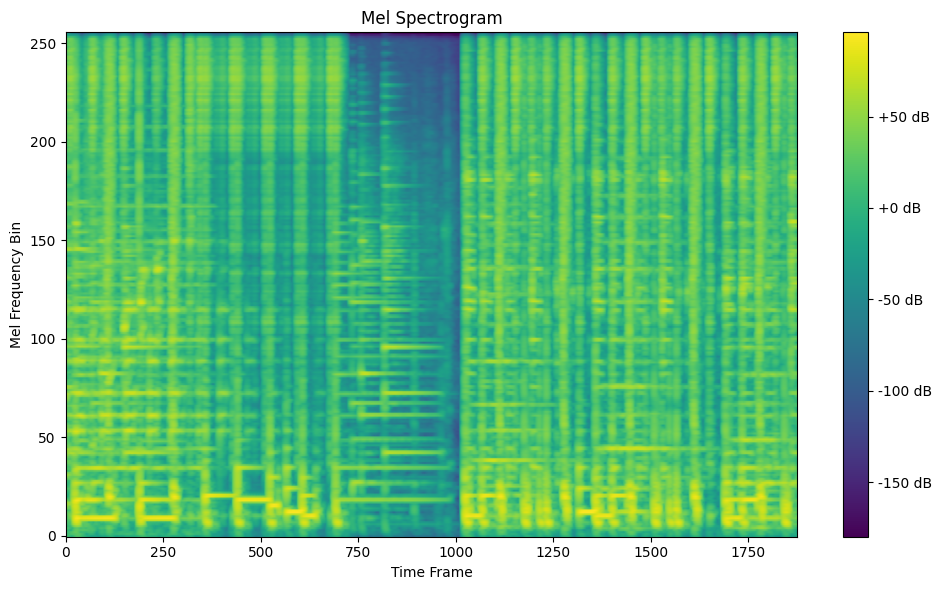

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the mel spectrogram to a numpy array for plotting
mel_spec_np = mel_spec.squeeze().cpu().numpy()  # Remove channel dimension and move to CPU

# Convert amplitude to decibels for better visualization (log scale)
mel_spec_db = 20 * np.log10(mel_spec_np + 1e-9)  # Add small epsilon to avoid log(0)

# Create the plot
plt.figure(figsize=(10, 6))
plt.imshow(mel_spec_db, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.ylabel('Mel Frequency Bin')
plt.xlabel('Time Frame')
plt.tight_layout()
plt.show()

In [172]:
from torchaudio.transforms import MelSpectrogram, InverseMelScale, GriffinLim

In [187]:
# Step 1: Convert mel spectrogram back to linear spectrogram
inverse_mel = InverseMelScale(
    n_stft=(N_FFT//2 + 1),  # n_fft//2 + 1 = 2048//2 + 1 = 1025
    n_mels=N_MELS,
    sample_rate=16000
).to(mel_spec.device)

# Convert mel spectrogram to linear scale
linear_spec = inverse_mel(mel_spec)

# Step 2: Use Griffin-Lim to reconstruct waveform
griffin_lim = GriffinLim(
    n_fft=N_FFT,
    hop_length=128,
    win_length=2048,
    power=1.0,  # Use 1.0 for magnitude spectrograms
    n_iter=200,  # More iterations can improve quality
    rand_init=True
).to(linear_spec.device)

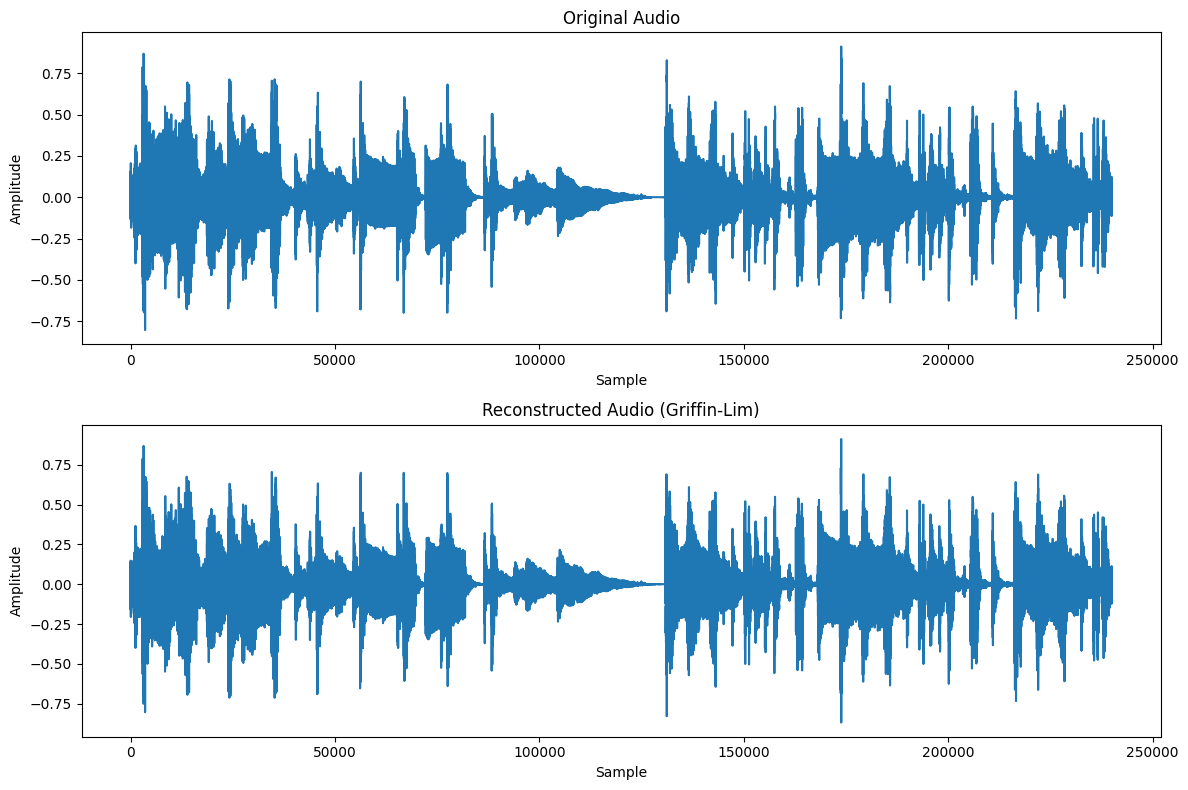

In [188]:
reconstructed_sign = griffin_lim(linear_spec)

reconstructed_audio = torch.sign(reconstructed_sign) * torch.abs(audio_data)



# Remove channel dimension if needed
if reconstructed_audio.dim() > 1:
    reconstructed_audio = reconstructed_audio.squeeze(0)

# Convert to numpy for playback or saving
reconstructed_audio_np = reconstructed_audio.detach().cpu().numpy()

# Plot original and reconstructed audio for comparison
plt.figure(figsize=(12, 8))

# Original audio
plt.subplot(2, 1, 1)
plt.plot(audio_data.squeeze().cpu().numpy())
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Reconstructed audio
plt.subplot(2, 1, 2)
plt.plot(reconstructed_audio_np)
plt.title('Reconstructed Audio (Griffin-Lim)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [189]:
Audio(data=audio_data, rate=16000, autoplay=False)

In [190]:
Audio(data=reconstructed_audio_np, rate=16000, autoplay=False)

In [143]:
audio_data

tensor([[-0.0876, -0.1320, -0.1154,  ..., -0.0754, -0.0516, -0.0139]])

In [144]:
reconstructed_audio

tensor([ 0.2806, -0.1726,  0.0335,  ..., -1.6937,  1.4217,  2.0044])

Text(0, 0.5, 'Amplitude')

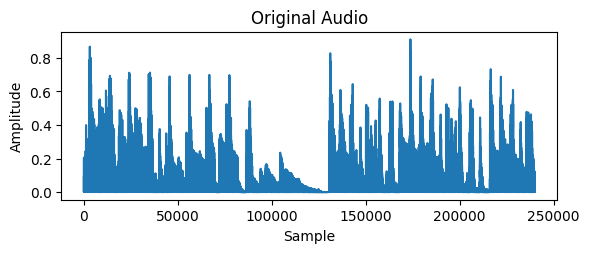

In [154]:


plt.subplot(2, 1, 1)
plt.plot(torch.abs(audio_data).squeeze().cpu().numpy())
plt.title('Original Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

In [191]:
(torch.sign(audio_data) == torch.sign(reconstructed_audio)).float().mean()

tensor(0.5284)